In [100]:
import numpy as np
import torch 
import pandas as pd
from pickle import FALSE, TRUE
from scipy.stats import norm 
import itertools
from itertools import repeat 
import scipy.stats as sts 
from torch.distributions import Normal  
import time
import cProfile as profile
import pstats
import seaborn as sns
import importlib
from plotnine import *
import time

# for profiling
import cProfile, pstats, io
from pstats import SortKey

# helper functions from within the library
import helper
import init_params_tensor
import init_params
import init_model_tensor
import init_model

import params_search as ps
# import main_sim
import main_sim
import main_sim_tensor
import compute_prob_tensor
import compute_prob


# Consolidated comparison

In [59]:
importlib.reload(helper)
importlib.reload(compute_prob)
importlib.reload(compute_prob_tensor)
importlib.reload(init_params_tensor)
importlib.reload(init_params)
importlib.reload(init_model_tensor)
importlib.reload(init_model)
importlib.reload(main_sim_tensor)
importlib.reload(ps)

<module 'params_search' from '/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/params_search.py'>

## original 

In [63]:
o_param = init_params.granch_params(
      grid_mu_theta = torch.linspace(start = -1, end = 1, steps = 5),
      grid_sig_sq = torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 3), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      hypothetical_obs_grid_n = 5, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)


o_param.add_meshed_grid()
o_param.add_lp_mu_sig_sq()
o_param.add_y_given_mu_sig_sq()
o_param.add_lp_epsilon()
o_param.add_priors()

stimuli = init_model.granch_stimuli(1, 'BBBBBB')
model = init_model.granch_model(500, stimuli)


o_res = main_sim.granch_main_simulation(o_param, model, stimuli)
#print(stimuli)
#print(o_res.behavior)


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob.py:149: RuntimeWarning: divide by zero encountered in log
  return np.log(res) if log else res


## tensor

In [61]:
# initialize parameters
params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = 5),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 3), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      hypothetical_obs_grid_n = 5, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

# add the various different cached bits
params.add_meshed_grid()
params.add_lp_mu_sigma()
params.add_y_given_mu_sigma()
params.add_lp_epsilon()
params.add_priors()

# initialize the model
tensor_stimuli = init_model_tensor.granch_stimuli(1, 'BBBBBB')
tensor_model = init_model_tensor.granch_model(500, tensor_stimuli)


res = main_sim_tensor.granch_main_simulation(params, tensor_model, stimuli)
print(res.behavior)


    stimulus_id       EIG Look_away
0             0  0.035864     False
1             0  0.034931     False
2             0  0.026614     False
3             0  0.016764     False
4             0  0.009322     False
..          ...       ...       ...
495         NaN       NaN       NaN
496         NaN       NaN       NaN
497         NaN       NaN       NaN
498         NaN       NaN       NaN
499         NaN       NaN       NaN

[500 rows x 3 columns]


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
  return torch.from_numpy(np.log(res)) if log else torch.from_numpy(res)


# Visualizing the comparison 

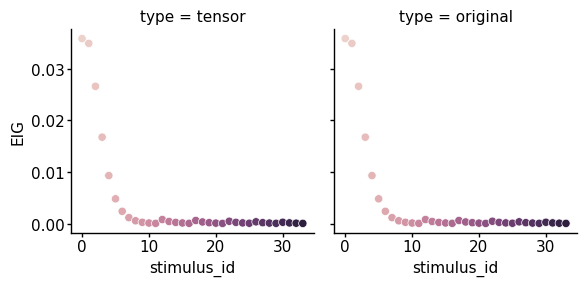

In [120]:
def compare_eig(res, o_res):
    behavior = res.behavior 
    behavior["type"] = "tensor"
    o_behavior = o_res.behavior
    o_behavior["type"] = "original"

    c_df = pd.concat([behavior, o_behavior])
    c_df = c_df.dropna(subset = ["stimulus_id"])

    c_df['stimulus_id'] = c_df.index
    

    p = sns.FacetGrid(c_df, col="type")
    p.map_dataframe(sns.scatterplot, x="stimulus_id", y = "EIG", hue = "stimulus_id")
    return (p)
    #return (c_df)

    #



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

compare_eig(res, o_res)




# Timing 

In [124]:
def compare_timing(step_n, hypo_observation_n):

    # time the original one
    o_start_time = time.perf_counter()

    o_param = init_params.granch_params(
      grid_mu_theta = torch.linspace(start = -1, end = 1, steps = step_n),
      grid_sig_sq = torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      grid_y = torch.linspace(start = -1, end = 1, steps = step_n), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      hypothetical_obs_grid_n = hypo_observation_n, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)


    o_param.add_meshed_grid()
    o_param.add_lp_mu_sig_sq()
    o_param.add_y_given_mu_sig_sq()
    o_param.add_lp_epsilon()
    o_param.add_priors()

    stimuli = init_model.granch_stimuli(1, 'BBBBBB')
    model = init_model.granch_model(500, stimuli)
    o_res = main_sim.granch_main_simulation(o_param, model, stimuli)

    o_end_time = time.perf_counter()
    o_elapsed_time = o_end_time - o_start_time

    # time the tensor one

    start_time = time.perf_counter()
    params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = step_n),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      grid_y = torch.linspace(start = -1, end = 1, steps = step_n), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      hypothetical_obs_grid_n = hypo_observation_n, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

  # add the various different cached bits
    params.add_meshed_grid()
    params.add_lp_mu_sigma()
    params.add_y_given_mu_sigma()
    params.add_lp_epsilon()
    params.add_priors()

    # initialize the model
    tensor_stimuli = init_model_tensor.granch_stimuli(1, 'BBBBBB')
    tensor_model = init_model_tensor.granch_model(500, tensor_stimuli)
    
    res = main_sim_tensor.granch_main_simulation(params, tensor_model, stimuli)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time

    compare_eig(res, o_res)

    timed_res = {
        "type": ["original", "tensor"], 
        't': [o_elapsed_time, elapsed_time], 
        "grid_step": [step_n, step_n], 
        "hypo_n": [hypo_observation_n, hypo_observation_n]
    }

    return (timed_res)








/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob.py:149: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


,type,t,grid_step,hypo_n
0,original,29.004294,10,5
1,tensor,0.346344,10,5


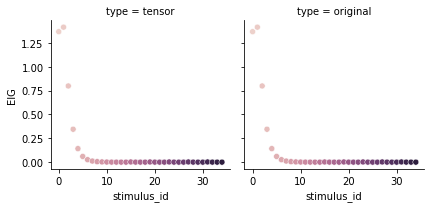

In [130]:
pd.DataFrame(compare_timing(10, 5))

# Profiling of initial model with group_by_logsumexp

In [8]:
pr = cProfile.Profile()
pr.enable()
res = main_sim.granch_main_simulation(p, m, s)
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

NameError: name 'main_sim' is not defined

<AxesSubplot:xlabel='index_column', ylabel='EIG'>

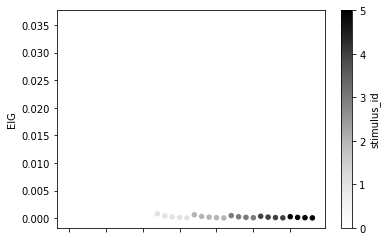

In [64]:
res.behavior['index_column'] = res.behavior.index
res.behavior.plot.scatter(x = "index_column", y = "EIG", c = "stimulus_id")

# Profiling of improved logsumexp

In [ ]:
pr = cProfile.Profile()
pr.enable()
res = main_sim.granch_main_simulation(p, m, s)
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         157214 function calls (154501 primitive calls) in 9.998 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    9.998    4.999 /Users/mcfrank/Projects/pokebaby/looking_time_models/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406(run_code)
        2    0.000    0.000    9.998    4.999 {built-in method builtins.exec}
        1    0.000    0.000    9.998    9.998 /var/folders/c1/4_sgh_lx3h5c7c8r9w3xs6f00000gq/T/ipykernel_57633/2873141792.py:3(<module>)
        1    0.009    0.009    9.998    9.998 /Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/main_sim.py:39(granch_main_simulation)
      252    0.050    0.000    8.420    0.033 /Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/helper.py:49(group_by_logsumexp_improved)
  504/252    0.002    0.000    6.874    0.027 /Users/mcfrank/Projects/pokebaby/looking_time_models/.venv/lib/python3.9/

<AxesSubplot:xlabel='index_column', ylabel='EIG'>

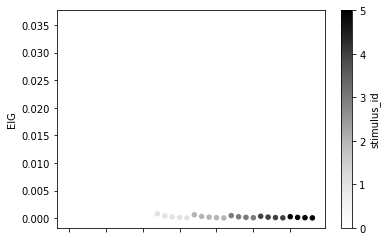

In [66]:
res.behavior['index_column'] = res.behavior.index
res.behavior.plot.scatter(x = "index_column", y = "EIG", c = "stimulus_id")